# Tutorial 4: Model Validation and Calibration Test
Credit: Tri Nguyen and Claude Code

In this tutorial, we'll perform some validation tests on an NPE model.

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from scipy.stats import multivariate_normal

# Install sampling packages if needed
try:
    import tarp
    print("tarp library is already installed.")
except ImportError:
    # install tarp (which requires deprecation)
    !pip install deprecation tarp
    import tarp
    print("tarp library installed successfully.")

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("Libraries imported successfully!")

tarp library is already installed.
Libraries imported successfully!


We'll quickly train a simple NPE model on Gaussian data. Then we'll perform calibration tests using (1) a simple rank-based calibration test and (2) a more advanced test using TARP [(Lemos et al. 2023)](https://arxiv.org/abs/2302.03026).

We'll skip most of the steps for training NPE models, as they were covered in the previous tutotrials.

In [3]:
def sample_gaussian_simulator(
    n_samples,
    theta_mean=0.0,
    theta_std=1.0,
    a=1.0,
    b=0.0,
    noise_std=0.5
):
    """
    Sample from Gaussian simulator: x = a*θ + b + ε

    Prior: θ ~ N(theta_mean, theta_std^2)
    Likelihood: x | θ ~ N(a*θ + b, noise_std^2)

    Parameters:
    - n_samples: number of samples
    - theta_mean: mean of prior p(θ)
    - theta_std: std of prior p(θ)
    - a: slope of linear relationship
    - b: intercept
    - noise_std: observational noise level

    Returns:
    - theta: (n_samples,) parameter values
    - x: (n_samples,) observation values
    """
    # Sample θ from prior
    theta = np.random.normal(theta_mean, theta_std, size=n_samples)

    # Sample x | θ = a*θ + b + ε
    noise = np.random.normal(0, noise_std, size=n_samples)
    x = a * theta + b + noise

    return theta, x

class GaussianPosterior(nn.Module):
    """
    Neural network that models p(θ|x) as a Gaussian.

    Input: x (observation)
    Output: mean μ(x) and std σ(x) for p(θ|x)
    """

    def __init__(self, hidden_size=64):
        super().__init__()

        self.network = nn.Sequential(
            nn.Linear(1, hidden_size),  # input dimension is 1
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
        )

        # Output layers for mean and log std of Gaussian
        self.mean_layer = nn.Linear(hidden_size, 1)
        self.logstd_layer = nn.Linear(hidden_size, 1)

    def forward(self, x):
        """Predict Gaussian parameters μ(x), σ(x)"""
        features = self.network(x)
        mean = self.mean_layer(features)
        logstd = self.logstd_layer(features)
        return mean, logstd

    def log_prob(self, theta, x):
        """Compute log p(θ|x)"""
        mean, logstd = self.forward(x)
        var = torch.exp(2 * logstd)
        log_prob = -0.5 * (np.log(2 * np.pi) + 2 * logstd + ((theta - mean) ** 2) / var)
        return log_prob

    def sample(self, x, n_samples=1000):
        """Sample θ ~ p(θ|x)"""
        mean, logstd = self.forward(x)
        mean = torch.repeat_interleave(mean.unsqueeze(-1), n_samples, dim=1)
        logstd = torch.repeat_interleave(logstd.unsqueeze(-1), n_samples, dim=1)
        samples = mean + torch.exp(logstd) * torch.randn(x.shape[0], n_samples, 1)
        return samples

def train_model(model, theta_train, x_train, epochs=50, batch_size=256, lr=1e-3):
    """
    Train the posterior model.
    """
    theta_tensor = torch.tensor(theta_train, dtype=torch.float32).reshape(-1, 1)
    x_tensor = torch.tensor(x_train, dtype=torch.float32).reshape(-1, 1)

    dataset = TensorDataset(x_tensor, theta_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    losses = []
    print(f"Training for {epochs} epochs...\n")

    for epoch in range(epochs):
        epoch_loss = 0.0
        n_batches = 0

        for x_batch, theta_batch in dataloader:
            optimizer.zero_grad()
            log_prob = model.log_prob(theta_batch, x_batch)
            loss = -log_prob.mean()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            n_batches += 1

        avg_loss = epoch_loss / n_batches
        losses.append(avg_loss)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1:3d}/{epochs} | Loss: {avg_loss:.4f}")

    print("\n✓ Training complete!")
    return losses

We will train the model on Gaussian data with a known noise level. During validation, we will experiment with both the correct noise level and an incorrect noise level to see how the calibration tests respond.

In [4]:
# Generate training data
n_training = 10_000
noise_std = 1.0
print(f"Generating {n_training} training samples...")

theta_train, x_train = sample_gaussian_simulator(n_training, noise_std=noise_std)

print(f"✓ Training data generated")
print(f"  θ shape: {theta_train.shape}")
print(f"  x shape: {x_train.shape}")

gaussian_model = GaussianPosterior(hidden_size=64)
gauss_losses = train_model(gaussian_model, theta_train, x_train, epochs=50)

Generating 10000 training samples...
✓ Training data generated
  θ shape: (10000,)
  x shape: (10000,)
Training for 50 epochs...

Epoch  10/50 | Loss: 1.0834
Epoch  20/50 | Loss: 1.0822
Epoch  30/50 | Loss: 1.0783
Epoch  40/50 | Loss: 1.0779
Epoch  50/50 | Loss: 1.0831

✓ Training complete!


Now that the model is trained, we will perform some validation tests. First, we generate three sets of test datasets:

1. Gaussian data with the same parameters as the training data (well-specified model).
2. Gaussian data with a larger noise level.
3. Gaussian data with a smaller noise level.

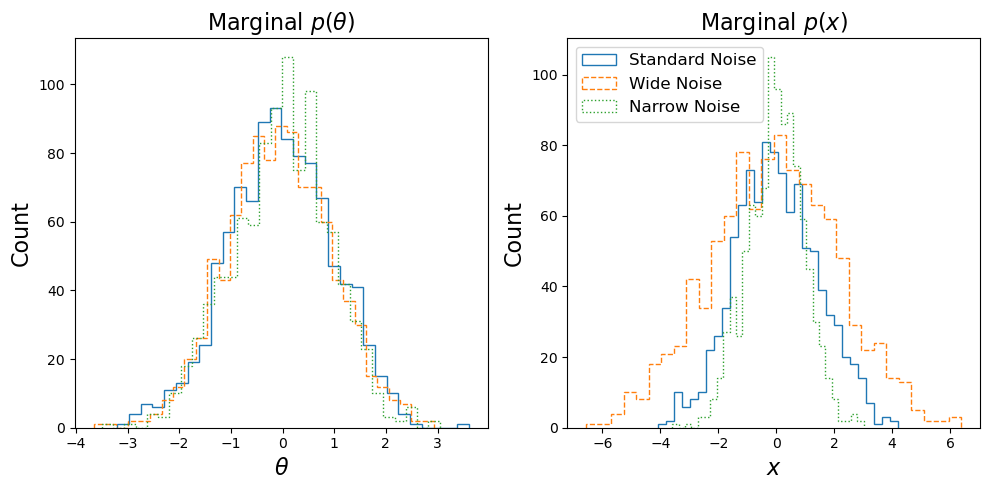

In [5]:
# Generate a test dataset with different noise levels
# feel free to play around with the noise levels, or even shifted the means and slopes
theta_test, x_test = sample_gaussian_simulator(
    1000, a=1, b=0, noise_std=noise_std)
theta_test_wide, x_test_wide = sample_gaussian_simulator(
    1000, a=1, b=0, noise_std=noise_std*2)
theta_test_narrow, x_test_narrow = sample_gaussian_simulator(
    1000, a=1, b=0, noise_std=noise_std*0.1)

# Plot the example test dataset to visualize the effect of different noise levels
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].hist(theta_test, bins=30, color='C0', histtype='step')
axes[0].hist(theta_test_wide, bins=30, color='C1', histtype='step', linestyle='dashed')
axes[0].hist(theta_test_narrow, bins=30, color='C2', histtype='step', linestyle='dotted')
axes[0].set_xlabel(r'$\theta$', fontsize=16)
axes[0].set_ylabel('Count', fontsize=16)
axes[0].set_title(r'Marginal $p(\theta)$', fontsize=16)

axes[1].hist(
    x_test, bins=30, color='C0', histtype='step', label='Standard Noise')
axes[1].hist(
    x_test_wide, bins=30, color='C1', histtype='step', linestyle='dashed', label='Wide Noise')
axes[1].hist(
    x_test_narrow, bins=30, color='C2', histtype='step', linestyle='dotted', label='Narrow Noise')
axes[1].set_xlabel(r'$x$', fontsize=16)
axes[1].set_ylabel('Count', fontsize=16)
axes[1].set_title(r'Marginal $p(x)$', fontsize=16)

axes[1].legend(fontsize=12)

plt.tight_layout()
plt.show()


In [6]:
def sample_posteriors(model, x_values, n_samples=1000):
    """
    Sample from the posterior p(θ|x) for given x values.
    """
    x_tensor = torch.tensor(x_values, dtype=torch.float32).reshape(-1, 1)
    with torch.no_grad():
        samples = model.sample(x_tensor, n_samples=n_samples)
    return samples.numpy().squeeze()

theta_samples = sample_posteriors(gaussian_model, x_test, n_samples=2000)
theta_samples_wide = sample_posteriors(gaussian_model, x_test_wide, n_samples=2000)
theta_samples_narrow = sample_posteriors(gaussian_model, x_test_narrow, n_samples=2000)

## Understanding Calibration Tests

When we train a model to predict posterior distributions p(θ|x), it's crucial to verify that these predictions are **calibrated**. A calibrated model produces posterior distributions that accurately reflect the true uncertainty in our predictions.

### What is Calibration?

A well-calibrated posterior should satisfy:
- If we draw a true parameter $\theta^\star$ from $p(\theta|x)$ and claim "$\theta^\star$ is in the 68% credible interval", this should be true 68% of the time
- More generally, for any credibility level $\alpha$, the true parameter should fall within the $\alpha$-credible region exactly $\alpha$ fraction of the time

If a model is **under-confident** (posteriors too wide), the true parameters will fall inside credible regions more often than expected.
If a model is **over-confident** (posteriors too narrow), the true parameters will fall outside credible regions more often than expected.

### Rank-Based Calibration Test

The rank-based test is a simple but powerful way to check calibration. Here's how it works:

1. **Generate test data**: Sample pairs $(\theta^\star, x^\star)$ from the joint distribution $p(\theta, x)$
2. **Draw posterior samples**: For each $x^\star$, draw N samples from the predicted posterior $p(\theta|x^\star)$
3. **Compute ranks**: For each test case, count how many posterior samples are less than $\theta^\star$* (the "rank")
4. **Check uniformity**: If the model is calibrated, these ranks should be uniformly distributed in $[0, N]$

**Intuition**: Imagine you draw 100 samples from $p(\theta|x^\star)$). If the model is well-calibrated, the true value $\theta^\star$ should be equally likely to be the smallest, largest, or anywhere in between. If $\theta^\star$ consistently falls in the middle, the posterior is too wide (under-confident). If $\theta^\star$ is often at the extremes, the posterior is too narrow (over-confident).

**Mathematical foundation**: For a well-calibrated model, the probability integral transform
$$\text{rank}(\theta^*) = \int_{-\infty}^{\theta^*} p(\theta|x^*) d\theta$$
should follow a uniform distribution $U(0,1)$.

In practice, instead of computing the integral, we approximate it using posterior samples:
$$\text{rank}(\theta^*) \approx \frac{1}{N} \sum_{i=1}^{N} \mathbb{I}[\theta_i < \theta^*]$$
where $\theta_i$ are samples from $p(\theta|x^*)$ and $\mathbb{I}$ is the indicator function.

Now let's implement this test:

In [7]:
def rank_based_calibration(theta_true, theta_samples):
    """
    Compute ranks for the rank-based calibration test.

    Parameters:
    - theta_true: (n_tests,) array of true parameter values
    - theta_samples: (n_tests, n_samples) array of posterior samples

    Returns:
    - ranks: (n_tests,) array of ranks (normalized to [0, 1])
    """
    n_tests, n_samples = theta_samples.shape

    # For each test case, count how many samples are less than the true value
    ranks = np.sum(theta_samples < theta_true.reshape(-1, 1), axis=1)

    # Normalize ranks to [0, 1]
    normalized_ranks = ranks / n_samples

    return normalized_ranks

# Compute ranks for all three test datasets
ranks_standard = rank_based_calibration(theta_test, theta_samples)
ranks_wide = rank_based_calibration(theta_test_wide, theta_samples_wide)
ranks_narrow = rank_based_calibration(theta_test_narrow, theta_samples_narrow)

print(f"Rank statistics for standard noise:")
print(f"  Mean: {ranks_standard.mean():.3f} (expected: 0.500)")
print(f"  Std:  {ranks_standard.std():.3f} (expected: {1/np.sqrt(12):.3f})")
print()
print(f"Rank statistics for wide noise (model should be over-confident):")
print(f"  Mean: {ranks_wide.mean():.3f} (expected: 0.500)")
print(f"  Std:  {ranks_wide.std():.3f} (expected: {1/np.sqrt(12):.3f})")
print()
print(f"Rank statistics for narrow noise (model should be under-confident):")
print(f"  Mean: {ranks_narrow.mean():.3f} (expected: 0.500)")
print(f"  Std:  {ranks_narrow.std():.3f} (expected: {1/np.sqrt(12):.3f})")

Rank statistics for standard noise:
  Mean: 0.490 (expected: 0.500)
  Std:  0.288 (expected: 0.289)

Rank statistics for wide noise (model should be over-confident):
  Mean: 0.504 (expected: 0.500)
  Std:  0.352 (expected: 0.289)

Rank statistics for narrow noise (model should be under-confident):
  Mean: 0.503 (expected: 0.500)
  Std:  0.227 (expected: 0.289)


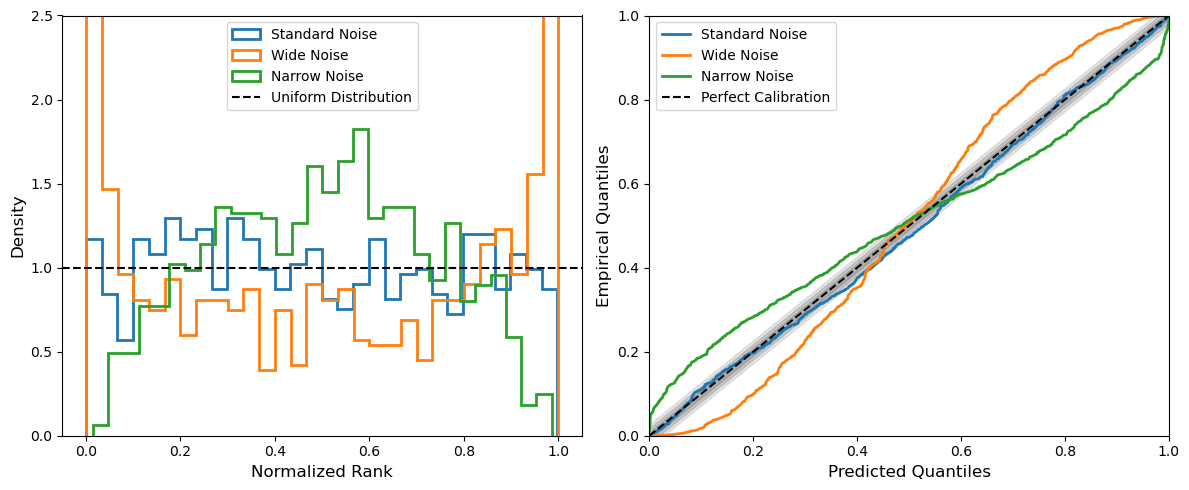

In [41]:
from scipy import stats

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Histograms comparing all three
ax = axes[0]
ax.hist(ranks_standard, bins=30, color='C0', label='Standard Noise', density=True, histtype='step', linewidth=2)
ax.hist(ranks_wide, bins=30, color='C1', label='Wide Noise', density=True, histtype='step', linewidth=2)
ax.hist(ranks_narrow, bins=30, color='C2', label='Narrow Noise', density=True, histtype='step', linewidth=2)
ax.axhline(1.0, color='black', linestyle='--', label='Uniform Distribution')
ax.set_xlabel('Normalized Rank', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.legend()
ax.set_ylim([0, 2.5])

ax = axes[1]
# Standard noise
sorted_ranks = np.sort(ranks_standard)
theoretical_quantiles = np.linspace(0, 1, len(sorted_ranks))
ax.plot(theoretical_quantiles, sorted_ranks, '-', lw=2, color='C0', label='Standard Noise')
# Wide noise
sorted_ranks_wide = np.sort(ranks_wide)
ax.plot(theoretical_quantiles, sorted_ranks_wide, '-', lw=2, color='C1', label='Wide Noise')
# Narrow noise
sorted_ranks_narrow = np.sort(ranks_narrow)
ax.plot(theoretical_quantiles, sorted_ranks_narrow, '-', lw=2, color='C2', label='Narrow Noise')

# Calculate the perfect calibration + some uncertainty
ax.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')

# 1, 2, 3 sigma confidence bands
# For uniform: standard error = 1/sqrt(12*n)
# Using Gaussian approximation for empirical quantiles
se = 1 / np.sqrt(12 * n)

sigmas = [1, 2, 3]
alphas = [0.4, 0.3, 0.2]
quantiles = np.linspace(0, 1, 100)
for sigma, alpha_val in zip(sigmas, alphas):
    lower_band = np.maximum(quantiles - sigma * se, 0)
    upper_band = np.minimum(quantiles + sigma * se, 1)

    ax.fill_between(
        quantiles, lower_band, upper_band,
        alpha=alpha_val, color='gray',
    )
ax.legend()
ax.set_xlabel('Predicted Quantiles', fontsize=12)
ax.set_ylabel('Empirical Quantiles', fontsize=12)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()

We can also perform a Kolmogorov-Smirnov (KS) test to see if the rank distribution follows a uniform distribution

In [44]:
from scipy.stats import kstest

ks_stat_standard, p_value_standard = kstest(ranks_standard, 'uniform')
ks_stat_wide, p_value_wide = kstest(ranks_wide, 'uniform')
ks_stat_narrow, p_value_narrow = kstest(ranks_narrow, 'uniform')

print(f"""Kolmogorov-Smirnov Test Results
(Tests if ranks are uniformly distributed)

Standard Noise:
  KS statistic: {ks_stat_standard:.4f}
  p-value: {p_value_standard:.4f}
  {'✓ Well calibrated' if p_value_standard > 0.05 else '✗ Poor calibration'}

Wide Noise:
  KS statistic: {ks_stat_wide:.4f}
  p-value: {p_value_wide:.4f}
  {'✓ Well calibrated' if p_value_wide > 0.05 else '✗ Poor calibration (over-confident)'}

Narrow Noise:
  KS statistic: {ks_stat_narrow:.4f}
  p-value: {p_value_narrow:.4f}
  {'✓ Well calibrated' if p_value_narrow > 0.05 else '✗ Poor calibration (under-confident)'}

Note: p-value > 0.05 suggests good calibration
""")

Kolmogorov-Smirnov Test Results
(Tests if ranks are uniformly distributed)

Standard Noise:
  KS statistic: 0.0320
  p-value: 0.2520
  ✓ Well calibrated

Wide Noise:
  KS statistic: 0.1100
  p-value: 0.0000
  ✗ Poor calibration (over-confident)

Narrow Noise:
  KS statistic: 0.0935
  p-value: 0.0000
  ✗ Poor calibration (under-confident)

Note: p-value > 0.05 suggests good calibration



## TARP Calibration Test

We will also perform the Tests of Accuracy with Random Points (TARP; [Lemos et al. 2023](https://arxiv.org/abs/2302.03026)). TARP is a sampling-based test specifically designed for high-dimensional posterior distributions and does not require explicit likelihood evaluation. With enough samples, [Lemos et al. 2023](https://arxiv.org/abs/2302.03026) demonstrates that TARP is both necessary and sufficient to test the accuracy of the posterior estimators. 

In [45]:
# Apply TARP
ecp, alpha = tarp.get_tarp_coverage(
    theta_samples.T.reshape(2000, -1, 1),  # samples need to have shape (n_samples, n_tests, dim)
    theta_test.reshape(1000, 1), # true parameters need to have shape (n_tests, dim)
    bootstrap=True
)
ecp_wide, alpha_wide = tarp.get_tarp_coverage(
    theta_samples_wide.T.reshape(2000, -1, 1),
    theta_test.reshape(1000, 1), # true parameters need to have shape (n_tests, dim)
    bootstrap=True,
)
ecp_narrow, alpha_narrow = tarp.get_tarp_coverage(
    theta_samples_narrow.T.reshape(2000, -1, 1),
    theta_test.reshape(1000, 1), # true parameters need to have shape (n_tests, dim)
    bootstrap=True,
)

100%|██████████| 100/100 [00:01<00:00, 76.33it/s]


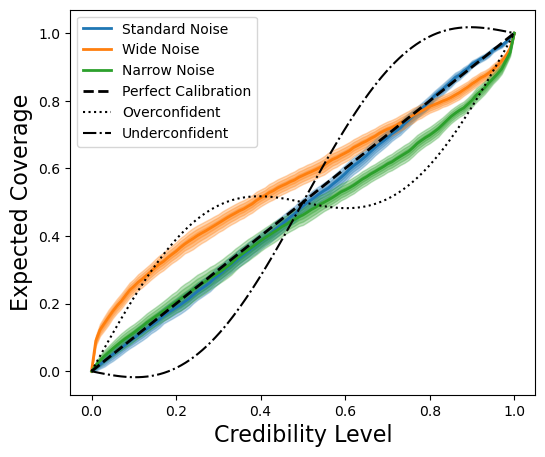

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

# Plot ECP curves and 1, 2, 3 sigma

# plot the bootstrapping mean and perfect calibration line
ax.plot(alpha, ecp.mean(axis=0), label='Standard Noise', color='C0', linewidth=2)
ax.plot(alpha_wide, ecp_wide.mean(axis=0), label='Wide Noise', color='C1', linewidth=2)
ax.plot(alpha_narrow, ecp_narrow.mean(axis=0), label='Narrow Noise', color='C2', linewidth=2)
ax.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration', linewidth=2)

for k in [1, 2, 3]:
    ax.fill_between(
        alpha,
        ecp.mean(axis=0) -  k * ecp.std(axis=0),
        ecp.mean(axis=0) + k * ecp.std(axis=0),
        color='C0', alpha=0.3)
    ax.fill_between(
        alpha_wide,
        ecp_wide.mean(axis=0) -  k * ecp_wide.std(axis=0),
        ecp_wide.mean(axis=0) + k * ecp_wide.std(axis=0),
        color='C1', alpha=0.3)
    ax.fill_between(
        alpha_narrow,
        ecp_narrow.mean(axis=0) -  k * ecp_narrow.std(axis=0),
        ecp_narrow.mean(axis=0) + k * ecp_narrow.std(axis=0),
        color='C2', alpha=0.3)


# S-shaped regions for TARP
x_region = np.linspace(0, 1, 100)

# Overconfident: S-curve that's BELOW at low credibility, ABOVE at high credibility
# Underconfident: S-curve that's ABOVE at low credibility, BELOW at high credibility
overconfident_curve = x_region + 0.2 * np.sin(2 * np.pi * x_region)
underconfident_curve = x_region - 0.2 * np.sin(2 * np.pi * x_region)

ax.plot(x_region, overconfident_curve, color='k', ls='dotted', label='Overconfident')
ax.plot(x_region, underconfident_curve, color='k', ls='dashdot', label='Underconfident')

ax.set_xlabel('Credibility Level', fontsize=16)
ax.set_ylabel('Expected Coverage', fontsize=16)
ax.legend()
plt.show()

Miscalibration manifests as S-shaped deviations from the diagonal: an **overconfident** posterior creates an S-curve that lies below the diagonal at low credibility levels and above at high levels, while an **underconfident** posterior shows the opposite pattern (above at low levels, below at high levels). 

**IMPORTANT**: TARP is a *binary* diagnostic - it tells you whether miscalibration exists but not the degree of miscalibration. The magnitude of deviation from the diagonal doesn't directly quantify how wrong your uncertainties are; it only indicates that the posterior is not properly calibrated. 

### Key Takeaways

Both rank-based and TARP tests successfully detect calibration issues:
1. **Well-specified model** (standard noise): Both tests confirm good calibration
2. **Over-confident model** (wide noise): Both detect that posteriors are too narrow
3. **Under-confident model** (narrow noise): Both detect that posteriors are too wide

The rank-based test is simpler to implement and interpret, but can only handle 1D or marginal posteriors. On the other hand, TARP can handle multivariate cases, but is tricker to interpret. Additionally, TARP does *NOT* tell you the degree to which the posterior is miscalibrated, only whether your posterior is calibrated or not. 